In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

In [2]:
using LinearAlgebra
using PyPlot
using ForwardDiff
using RobotZoo
using RobotDynamics
using MatrixCalculus

In [3]:
#Acrobot Dynamics
a = RobotZoo.Acrobot()
h = 0.05

0.05

In [4]:
# Parameters of the tractor-trailer
g_velocity = 0.5
g_tractor_wheelbase = 3.0
g_tractor_hitch_offset = 0.5
g_trailer_wheelbase = 6.0
max_alpha = atan(g_tractor_wheelbase/sqrt((g_trailer_wheelbase^2) - (g_tractor_hitch_offset^2)))

function tractor_trailer_qdot(q_current,u)
    
    # Variable to store the rate of change of state
    alpha = u
#     gear = 1
#     g_velocity = u[2]
    
    if(alpha!=0)
        r1 = g_tractor_wheelbase/tan(alpha);
        psi = -1*(alpha/abs(alpha))*atan(g_tractor_hitch_offset/abs(r1));
        va = (g_velocity/abs(g_velocity))*abs(((g_velocity*g_tractor_hitch_offset*tan(alpha))/(g_tractor_wheelbase*sin(psi))));
        vb = va*abs(cos(psi-q_current[4]));
        r2 = g_tractor_hitch_offset/sin(psi);
        r3 = g_trailer_wheelbase/sin(psi-q_current[4]);
        omega_1 = g_velocity*(1/r1);
        omega_2 = g_velocity*((r2)/(r1*r3));
        trailer_theta_dot = omega_2;
        beta_dot = g_velocity*(((r2)/(r1*r3)) - (1/r1));
    end

    # Special case when alpha equals zero
    if(alpha==0)
        va = g_velocity;
        psi = 0;
        phi = (pi/2) - (abs(q_current[4]) - (pi/2));
        hitch_turn_radius_zero_alpha = g_trailer_wheelbase/sin(phi);
        trailer_theta_dot = va/hitch_turn_radius_zero_alpha;
        beta_dot = trailer_theta_dot;
        vb = va*abs(cos(psi-q_current[4]));

        if(sin(phi)==0)
            beta_dot = 0;
            trailer_theta_dot = 0;
        end
        
    end
    

    q_dot = [vb*cos(q_current[3]); vb*sin(q_current[3]); trailer_theta_dot; beta_dot]

    return q_dot;
end

tractor_trailer_qdot (generic function with 1 method)

In [5]:
function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = RobotDynamics.dynamics(a, x, u)
    f2 = RobotDynamics.dynamics(a, x + 0.5*h*f1, u)
    f3 = RobotDynamics.dynamics(a, x + 0.5*h*f2, u)
    f4 = RobotDynamics.dynamics(a, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [6]:
function dfdx(x,u)
    ForwardDiff.jacobian(dx->dynamics_rk4(dx,u),x)
end

function dfdu(x,u)
    ForwardDiff.derivative(du->dynamics_rk4(x,du),u)
end

dfdu (generic function with 1 method)

In [7]:
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [18]:
# Cost weights
Q = Diagonal([1.0*ones(2); 0.1*ones(2)]);
R = 50;
Qn = Array(100.0*I(Nx));

In [19]:
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5*R*u*u
end

stage_cost (generic function with 1 method)

In [20]:
function terminal_cost(x)
    return 0.5*(x-xgoal)'*Qn*(x-xgoal)
end

terminal_cost (generic function with 1 method)

In [21]:
function cost(xtraj,utraj)
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[k])
    end
    J += terminal_cost(xtraj[:,Nt])
    return J
end

cost (generic function with 1 method)

In [22]:
#Initial guess
x0 = [0; 0; pi/2; pi]
xgoal = [0; 5; pi/2; pi]
xtraj = kron(ones(1,Nt), x0)
utraj = randn(Nt-1);

In [23]:
#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[k])
end
J = cost(xtraj,utraj)

4276.540008591817

In [24]:
#DDP Algorithm
p = zeros(Nx,Nt)
P = zeros(Nx,Nx,Nt)
d = ones(Nt-1)
K = zeros(Nu,Nx,Nt-1)
ΔJ = 0.0

xn = zeros(Nx,Nt)
un = zeros(Nt-1)

gx = zeros(Nx)
gu = 0.0
Gxx = zeros(Nx,Nx)
Guu = 0.0
Gxu = zeros(Nx)
Gux = zeros(Nx)

iter = 0
while maximum(abs.(d[:])) > 1e-3
    iter += 1
    
    p = zeros(Nx,Nt)
    P = zeros(Nx,Nx,Nt)
    d = ones(Nt-1)
    K = zeros(Nu,Nx,Nt-1)
    ΔJ = 0.0

    p[:,Nt] = Qn*(xtraj[:,Nt]-xgoal)
    P[:,:,Nt] = Qn
    
    #Backward Pass
    for k = (Nt-1):-1:1
        #Calculate derivatives
        q = Q*(xtraj[:,k]-xgoal)
        r = R*utraj[k]
    
        A = dfdx(xtraj[:,k], utraj[k]) #ForwardDiff.jacobian(dx->dynamics_rk4(dx,utraj[k]),xtraj[:,k])
        B = dfdu(xtraj[:,k], utraj[k]) #ForwardDiff.derivative(du->dynamics_rk4(xtraj[:,k],du),utraj[k])
    
        gx = q + A'*p[:,k+1]
        gu = r + B'*p[:,k+1]
    
        Gxx = Q + A'*P[:,:,k+1]*A 
        Guu = R + B'*P[:,:,k+1]*B 
        Gxu = A'*P[:,:,k+1]*B 
        Gux = B'*P[:,:,k+1]*A
        
        d[k] = Guu\gu
        K[:,:,k] .= Guu\Gux
    
        p[:,k] .= dropdims(gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[k] - Gxu*d[k], dims=2)
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
    
        ΔJ += gu'*d[k]
    end

    #Forward rollout with line search
    xn[:,1] = xtraj[:,1]
    α = 1.0

    for k = 1:(Nt-1)
        un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k],un[k])
    end
    Jn = cost(xn,un)
    
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α = 0.5*α
        for k = 1:(Nt-1)
            un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
            xn[:,k+1] .= dynamics_rk4(xn[:,k],un[k])
        end
        Jn = cost(xn,un)
    end
    #display(α)
    
    J = Jn
    xtraj .= xn
    utraj .= un
end

In [25]:
iter

3

In [26]:
J

1670.0828285738203

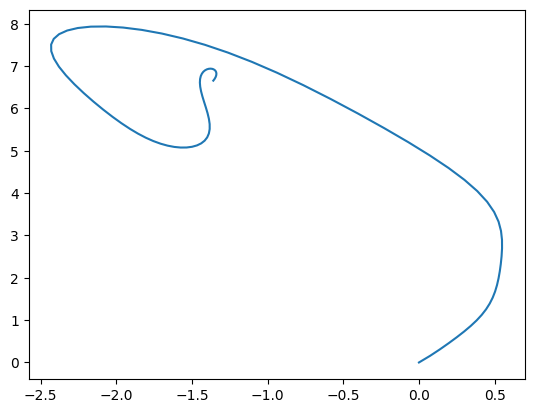

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f32bd057550>

In [27]:
# plot(thist,xtraj[1,:])
# plot(thist,xtraj[2,:])
plot(xtraj[1,:],xtraj[2,:])

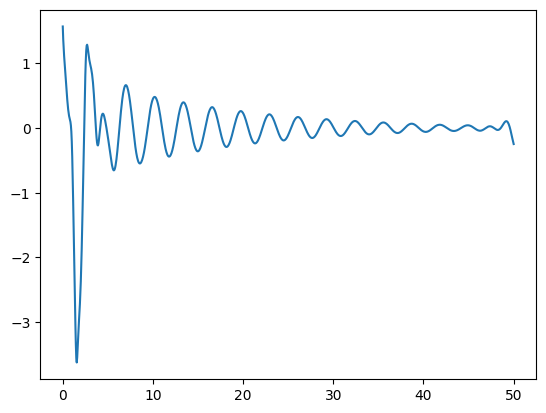

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2f396eda50>

In [81]:
plot(thist,xtraj[3,:])

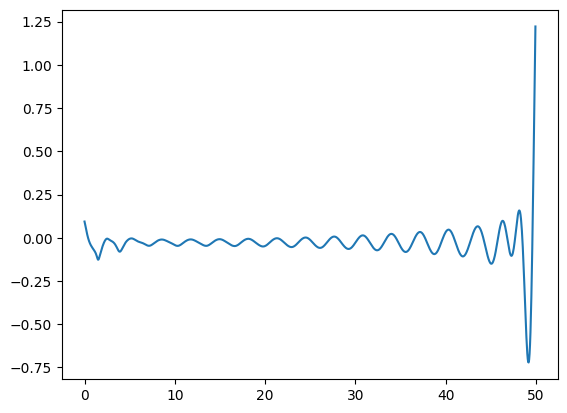

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2f4dac14b0>

In [75]:
plot(thist[1:Nt-1],utraj)

In [76]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8701))

In [77]:
TrajOptPlots.set_mesh!(vis, a)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8701

In [78]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)